In order to get comfortable with the data I decided to try to recreate the market option prices in the holdings file.  I used a variety of methods::

1. Using the market data provided (SPX implied volatility surface, risk-free rates, etc.) along with Black-Scholes-Merton (BSM) option pricing forumla.

2. Using the market data provided (SPX implied volatility surface, risk-free rates, etc.) along with a binomial-tree pricing function that I coded up.  My hope was that this would lead to more accurate pricing, because the SPY options are American.  But this didn't turn out to be the case.

3. Using BSM implied volatility from option prices with both the BSM and binomial models.  Obviously, this would recreate the option prices exactly when using the BSM pricing formulas, but I don't know if it would lead to the most accurate greeks.

This exercise led me to use market price implied vols, along with the BSM greeks formulas, to calculate my greeks in the next report.

## Importing Packages

Let's start by importing the core packages **numpy** and **pandas**.

In [ ]:
import numpy as np
import pandas as pd

## Reading-In Holdings File

Next, we read in the hodlings file that we cleaned in a prior notebook.

In [ ]:
df_holdings = pd.read_csv("../data/etf_holdings_clean_20240712.csv")
df_holdings

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,SharesOutstanding
0,2024-07-12,APRT,SPY,2025-03-31,3.87,C,553.2247,2129.00,1.177815e+08,100.65%,3175000
1,2024-07-12,APRT,SPY,2025-03-31,617.33,C,8.6830,-2129.00,-1.848611e+06,-1.58%,3175000
2,2024-07-12,APRT,SPY,2025-03-31,470.76,P,5.1659,-2129.00,-1.099820e+06,-0.94%,3175000
3,2024-07-12,APRT,SPY,2025-03-31,523.02,P,10.6462,2129.00,2.266576e+06,1.94%,3175000
4,2024-07-12,APRT,Cash&Other,NaN,NaN,NaN,1.0000,-91551.78,-9.155178e+04,-0.08%,3175000
...,...,...,...,...,...,...,...,...,...,...,...
169,2024-07-12,SIXZ,SPY,2024-10-31,3.71,C,555.1102,150.00,8.326653e+06,105.44%,300000
170,2024-07-12,SIXZ,SPY,2024-10-31,543.69,C,31.0701,-150.00,-4.660515e+05,-5.90%,300000
171,2024-07-12,SIXZ,SPY,2024-10-31,451.78,P,1.0376,-150.00,-1.556400e+04,-0.20%,300000
172,2024-07-12,SIXZ,SPY,2024-10-31,501.93,P,2.6020,150.00,3.903000e+04,0.49%,300000


## `D2X`, `UPX`, `Moneyness`, `RF`, `DIV`

At this point we can add a variety of columns, mostly from the data files that were provided for the assignment.  Notice that we use simple linear interpolation from **numpy** for the various curves.  In a more high stakes environment I might fit a parametric curve to the data to avoid overfitting.

In [ ]:
# adding D2X - this is business days to expiration.
from bizdays import Calendar
cal = Calendar.load("PMC/NYSE")

def bizdays(row):
    from_date = row["Date"]
    to_date = row["MaturityDate"]
    return cal.bizdays(from_date, to_date)

df_holdings["D2X"] = df_holdings.apply(bizdays, axis=1)

# adding UPX
df_spy = pd.read_csv("../data/spy_20240712.csv")
df_spy.dropna(inplace=True)
df_holdings["UPX"] = df_spy.query("date == '7/12/2024'").reset_index()['spy'][0]

# adding Moneyness
df_holdings["Moneyness"] = df_holdings["StrikePrice"] / df_holdings["UPX"]

# adding RF
df_risk_free = pd.read_csv("../data/rates_20240712.csv")

def risk_free(row):
    d2x = row["D2X"]
    return np.interp(d2x, df_risk_free["D2X"], df_risk_free["Close"])

df_holdings["RF"] = df_holdings.apply(risk_free, axis=1) / 100

# adding DIV
df_dividend = pd.read_csv("../data/spx_dividend_20240712.csv")
df_dividend["Date"] = pd.to_datetime('2024-07-12')
df_dividend["DivExpirationDate"] = pd.to_datetime(df_dividend["DivExpirationDate"], format="mixed", dayfirst=True)

def bizdays(row):
    from_date = row["Date"]
    to_date = row["DivExpirationDate"]
    return cal.bizdays(from_date, to_date)

df_dividend["D2X"] = df_dividend.apply(bizdays, axis=1)

def dividend(row):
    d2x = row["D2X"]
    dividend = np.interp(d2x, df_dividend["D2X"], df_dividend["DivCurve"])
    if dividend < 0:
        dividend = 0
    return dividend

df_holdings["Div"] = df_holdings.apply(dividend, axis=1)

# printing holdings dataframe
df_holdings

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,SharesOutstanding,D2X,UPX,Moneyness,RF,Div
0,2024-07-12,APRT,SPY,2025-03-31,3.87,C,553.2247,2129.00,1.177815e+08,100.65%,3175000,180.0,559.99,0.006911,0.049883,0.00596
1,2024-07-12,APRT,SPY,2025-03-31,617.33,C,8.6830,-2129.00,-1.848611e+06,-1.58%,3175000,180.0,559.99,1.102395,0.049883,0.00596
2,2024-07-12,APRT,SPY,2025-03-31,470.76,P,5.1659,-2129.00,-1.099820e+06,-0.94%,3175000,180.0,559.99,0.840658,0.049883,0.00596
3,2024-07-12,APRT,SPY,2025-03-31,523.02,P,10.6462,2129.00,2.266576e+06,1.94%,3175000,180.0,559.99,0.933981,0.049883,0.00596
4,2024-07-12,APRT,Cash&Other,NaN,NaN,NaN,1.0000,-91551.78,-9.155178e+04,-0.08%,3175000,NaN,559.99,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2024-07-12,SIXZ,SPY,2024-10-31,3.71,C,555.1102,150.00,8.326653e+06,105.44%,300000,78.0,559.99,0.006625,0.052484,0.00557
170,2024-07-12,SIXZ,SPY,2024-10-31,543.69,C,31.0701,-150.00,-4.660515e+05,-5.90%,300000,78.0,559.99,0.970892,0.052484,0.00557
171,2024-07-12,SIXZ,SPY,2024-10-31,451.78,P,1.0376,-150.00,-1.556400e+04,-0.20%,300000,78.0,559.99,0.806764,0.052484,0.00557
172,2024-07-12,SIXZ,SPY,2024-10-31,501.93,P,2.6020,150.00,3.903000e+04,0.49%,300000,78.0,559.99,0.896320,0.052484,0.00557


## `VolatilitySurface` Supplied SPX Vol Surface

Next, we add the implied volatility from the implied vol surface that was supplied.  Here we are using multi-dimensional linear interpolation, `LinearNDInterpolator`, from the **scipy** package.  Notice, that `LinearNDInterpolator` does not have built-in extrapolation functionality.  I did some research and this is intentional - the creators of **scipy** want users to create their own extrapolation logic.  I didn't want to bother for this analysis, so I just set a `fill_value=0.25`.  This was done by heuristically seeing which fixed `fill_value` led to the best price matching.  In a more high-stakes context I would probably create my own extrapolation logic.

In [ ]:
df_vol_surface = pd.read_csv("../data/spx_implied_volatility_20240712.csv")

d2x = df_vol_surface["D2X"].values.reshape(12, 9).T
moneyness = df_vol_surface["Moneyness"].values.reshape(12, 9)

points = np.array(np.meshgrid(d2x[0], moneyness[0])).T.reshape(-1, 2)

vols = df_vol_surface["BBG"].values.reshape(12, 9) / 100
values = vols.reshape(108)

from scipy.interpolate import LinearNDInterpolator
interp = LinearNDInterpolator(points, values, fill_value=0.25)

def vol_surface(row):
    d2x = row["D2X"]
    moneyness = row["Moneyness"]
    return np.round(interp(d2x, moneyness), 4)

df_holdings["VolatilitySurface"] = df_holdings.apply(vol_surface, axis=1)

df_holdings

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,SharesOutstanding,D2X,UPX,Moneyness,RF,Div,VolatilitySurface
0,2024-07-12,APRT,SPY,2025-03-31,3.87,C,553.2247,2129.00,1.177815e+08,100.65%,3175000,180.0,559.99,0.006911,0.049883,0.00596,0.2500
1,2024-07-12,APRT,SPY,2025-03-31,617.33,C,8.6830,-2129.00,-1.848611e+06,-1.58%,3175000,180.0,559.99,1.102395,0.049883,0.00596,0.1184
2,2024-07-12,APRT,SPY,2025-03-31,470.76,P,5.1659,-2129.00,-1.099820e+06,-0.94%,3175000,180.0,559.99,0.840658,0.049883,0.00596,0.2066
3,2024-07-12,APRT,SPY,2025-03-31,523.02,P,10.6462,2129.00,2.266576e+06,1.94%,3175000,180.0,559.99,0.933981,0.049883,0.00596,0.1690
4,2024-07-12,APRT,Cash&Other,NaN,NaN,NaN,1.0000,-91551.78,-9.155178e+04,-0.08%,3175000,NaN,559.99,NaN,NaN,NaN,0.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2024-07-12,SIXZ,SPY,2024-10-31,3.71,C,555.1102,150.00,8.326653e+06,105.44%,300000,78.0,559.99,0.006625,0.052484,0.00557,0.2500
170,2024-07-12,SIXZ,SPY,2024-10-31,543.69,C,31.0701,-150.00,-4.660515e+05,-5.90%,300000,78.0,559.99,0.970892,0.052484,0.00557,0.1348
171,2024-07-12,SIXZ,SPY,2024-10-31,451.78,P,1.0376,-150.00,-1.556400e+04,-0.20%,300000,78.0,559.99,0.806764,0.052484,0.00557,0.2461
172,2024-07-12,SIXZ,SPY,2024-10-31,501.93,P,2.6020,150.00,3.903000e+04,0.49%,300000,78.0,559.99,0.896320,0.052484,0.00557,0.1817


## `VolatilityImplied` Implied from Market Option Prices

Let's now calculate implied volatilities based on the market option prices.  In order to do this we use the **py_vollib** package which is great for Black-Scholes-Merton pricing calculations. We first have to convert the `implied_volatility()` function into a form that can be used in the **pandas** `DataFrame.apply()` method.

Note: for the deep ITM calls, the `implied_volatility()` function was throwing an error.  I think this is because there are tax/regulatory reasons why deep ITM calls can have a price that deviates from theoretically sound values.  Thus, for `Moneyness < 0.1`, I simply set the implied volatility equal to `0.25`.

In [ ]:
from py_vollib.black_scholes_merton.implied_volatility import implied_volatility

def implied_vol(row):
    underlying = row["Underlying"]
    if underlying == "Cash&Other":
        return(np.nan)
    
    cp = row["Type"].lower()
    upx = row["UPX"]
    strike = row["StrikePrice"]
    t2x = row["D2X"] / 252
    rf = row["RF"]
    price = row["Price"]
    q = row["Div"]
    if strike / upx < 0.1:
        vol = 0.25
    else:
        vol = implied_volatility(price, upx, strike, t2x, rf, q, cp)
    vol = np.round(vol, 4)
    return vol

df_holdings["VolatilityImplied"] = df_holdings.apply(implied_vol, axis=1)

df_holdings

,Date,Account,Underlying,MaturityDate,StrikePrice,Type,Price,Shares,MarketValue,Weightings,SharesOutstanding,D2X,UPX,Moneyness,RF,Div,VolatilitySurface,VolatilityImplied
0,2024-07-12,APRT,SPY,2025-03-31,3.87,C,553.2247,2129.00,1.177815e+08,100.65%,3175000,180.0,559.99,0.006911,0.049883,0.00596,0.2500,0.2500
1,2024-07-12,APRT,SPY,2025-03-31,617.33,C,8.6830,-2129.00,-1.848611e+06,-1.58%,3175000,180.0,559.99,1.102395,0.049883,0.00596,0.1184,0.1177
2,2024-07-12,APRT,SPY,2025-03-31,470.76,P,5.1659,-2129.00,-1.099820e+06,-0.94%,3175000,180.0,559.99,0.840658,0.049883,0.00596,0.2066,0.2063
3,2024-07-12,APRT,SPY,2025-03-31,523.02,P,10.6462,2129.00,2.266576e+06,1.94%,3175000,180.0,559.99,0.933981,0.049883,0.00596,0.1690,0.1675
4,2024-07-12,APRT,Cash&Other,NaN,NaN,NaN,1.0000,-91551.78,-9.155178e+04,-0.08%,3175000,NaN,559.99,NaN,NaN,NaN,0.2500,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2024-07-12,SIXZ,SPY,2024-10-31,3.71,C,555.1102,150.00,8.326653e+06,105.44%,300000,78.0,559.99,0.006625,0.052484,0.00557,0.2500,0.2500
170,2024-07-12,SIXZ,SPY,2024-10-31,543.69,C,31.0701,-150.00,-4.660515e+05,-5.90%,300000,78.0,559.99,0.970892,0.052484,0.00557,0.1348,0.1340
171,2024-07-12,SIXZ,SPY,2024-10-31,451.78,P,1.0376,-150.00,-1.556400e+04,-0.20%,300000,78.0,559.99,0.806764,0.052484,0.00557,0.2461,0.2347
172,2024-07-12,SIXZ,SPY,2024-10-31,501.93,P,2.6020,150.00,3.903000e+04,0.49%,300000,78.0,559.99,0.896320,0.052484,0.00557,0.1817,0.1777


## Creating Option Pricing Functions

Next, we create the the option pricing functions, for both Black-Scholes-Merton an the binomial model.  Notice, that just as above, they need to be converted into a form that can be used in the `DataFrame.apply()` method.

In [ ]:
from py_vollib.black_scholes_merton import black_scholes_merton

def bsm_px(row, vol_column):
    underlying = row["Underlying"]
    if underlying == "Cash&Other":
        return(np.nan)
    
    cp = row["Type"].lower()
    upx = row["UPX"]
    strike = row["StrikePrice"]
    t2x = row["D2X"] / 252
    rf = row["RF"]
    #volatility = row["Volatility"]
    volatility = row[vol_column]
    q = row["Div"]
    px = black_scholes_merton(cp, upx, strike, t2x, rf, volatility, q)
    px = np.round(px, 4)
    
    return(px)

In [ ]:
def crr_vanilla(cp, K, T, S0, vol, r, q, american=False, steps=1000):
    dt = T / steps                 # length of time-step
    u = np.exp(vol * np.sqrt(dt))  # up factor
    d = 1.0 / u                    # down factor
    a = np.exp((r-q)*dt)           # growth factor
    p = (a - d) / (u - d)          # risk-neutral up probability
    disc = np.exp(-r*dt)           # discount factor

    # initializing terminal underlying values
    S = S0 * (d**np.arange(steps, -1, -1)) * (u**np.arange(0, steps+1, 1))

    # value of option at final time step
    if cp == 'put':
        V = np.maximum(0, K - S)
    else:
        V = np.maximum(0, S - K)

    # backward recursion through the tree (only to the penultimate step so we can calculate delta)
    for i in np.arange(steps-1,0,-1): 
        S = (S * u)[0:-1] # a tricky way of calculating the previous underlying prices
        V =  disc * (p*V[1:i+2] + (1-p)*V[0:i+1])
        # check for early exercise
        if american:
            if cp == 'put':
                V = np.maximum(V, K - S)
            else:
                V = np.maximum(V, S - K)

    delta = (V[1] - V[0]) / (S[1] - S[0])
    price = disc * (p*V[1] + (1-p)*V[0])
    
    return price, delta

def crr_px(row, vol_column):
    underlying = row["Underlying"]
    if underlying == "Cash&Other":
        return(np.nan)
    
    cp = row["Type"].lower()
    if cp == "p":
        cp = "put"
    else:
        cp = "call"
    
    upx = row["UPX"]
    strike = row["StrikePrice"]
    t2x = row["D2X"] / 252
    rf = row["RF"]
    volatility = row[vol_column]
    q = row["Div"]
    px = crr_vanilla(cp, strike, t2x, upx, volatility, rf, q, american=True, steps=5000)[0]
    px = np.round(px, 4)
    
    return(px)

## Calculating & Comparing Option Prices

Now, let's use our `bsm_px()` and `crr_px` pricing functions in combination with the `VolatilitySurface` and `VolatilityImplied` to calculate and compare option prices.

Not suprisingly, from visual inspection we can see that the BSM + Implied has the tightest correlation to the market prices, which should be true by construction.  Note, that we are focused on relatively low priced options.

In [ ]:
import seaborn as sns

df_holdings["MyPriceBSMSurface"] = df_holdings.apply(bsm_px, vol_column="VolatilitySurface", axis=1)
df_holdings["MyPriceBSMImplied"] = df_holdings.apply(bsm_px, vol_column="VolatilityImplied", axis=1)
df_holdings["MyPriceAmericanSurface"] = df_holdings.apply(crr_px, vol_column="VolatilitySurface", axis=1)
df_holdings["MyPriceAmericanImplied"] = df_holdings.apply(crr_px, vol_column="VolatilityImplied", axis=1)

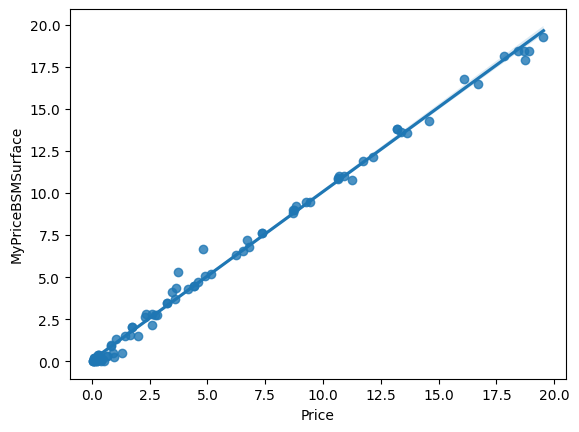

In [ ]:
sns.regplot(data=df_holdings.query("Price < 20"), x="Price", y="MyPriceBSMSurface",);

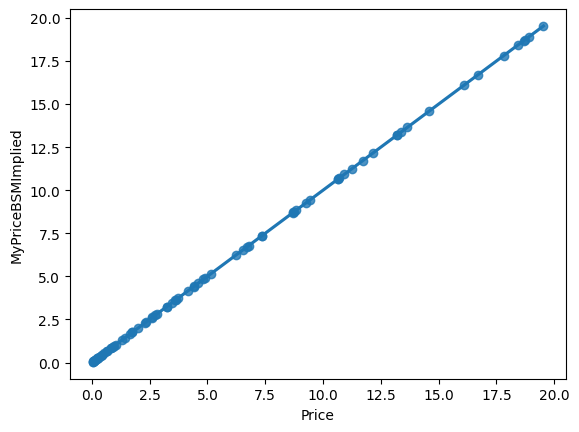

In [ ]:
sns.regplot(data=df_holdings.query("Price < 20"), x="Price", y="MyPriceBSMImplied",);

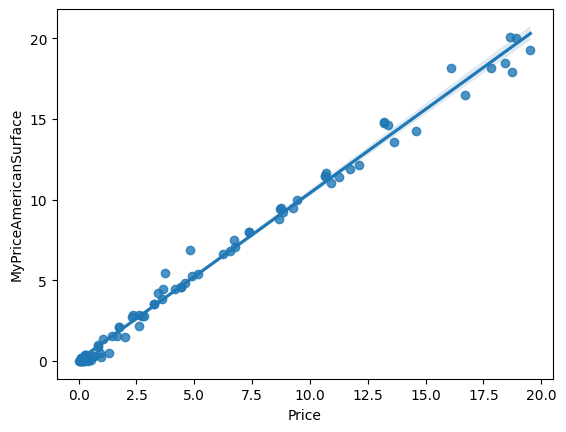

In [ ]:
sns.regplot(data=df_holdings.query("Price < 20"), x="Price", y="MyPriceAmericanSurface",);

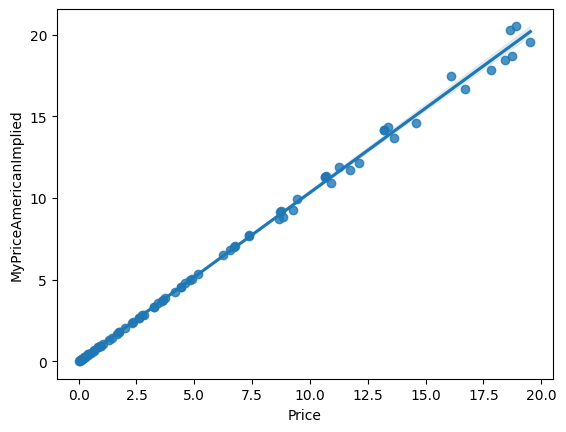

In [ ]:
sns.regplot(data=df_holdings.query("Price < 20"), x="Price", y="MyPriceAmericanImplied",);

Another simple measure of goodness of fit is the mean absolute error of market prices and cacluated prices.  We limit ourselves to options whose `Moneyness > 0.1` to avoid the deep ITM calls.  Again BSM + Implied performs the best, which should be true by construction.

In [ ]:
mae_bsm_surface = np.mean(np.abs(df_holdings.query("Moneyness > 0.1")['Price'] - df_holdings.query("Moneyness > 0.1")['MyPriceBSMSurface']))
mae_bsm_implied = np.mean(np.abs(df_holdings.query("Moneyness > 0.1")['Price'] - df_holdings.query("Moneyness > 0.1")['MyPriceBSMImplied']))
mae_american_surface = np.mean(np.abs(df_holdings.query("Moneyness > 0.1")['Price'] - df_holdings.query("Moneyness > 0.1")['MyPriceAmericanSurface']))
mae_american_implied = np.mean(np.abs(df_holdings.query("Moneyness > 0.1")['Price'] - df_holdings.query("Moneyness > 0.1")['MyPriceAmericanImplied']))

pd.DataFrame({
    'Method':['BSM + Surface', 'BSM + Implied', 'American + Surface', 'American + Implied'],
    'Mean Abs. Error': [mae_bsm_surface, mae_bsm_implied, mae_american_surface, mae_american_implied],
})

,Method,Mean Abs. Error
0,BSM + Surface,0.288006
1,BSM + Implied,0.002148
2,American + Surface,0.439133
3,American + Implied,0.176393


## Conclusion

For the purposes of calculating the portfolio greeks in the subsequent analyses I will use the implied volatilities from the market prices, along with the Black-Scholes-Merton formulas for the greeks.  I'm not entirely sure that this will lead to the most accurate greeks, but will be much more straight forward than using the binomial American model.